In [1]:
# Load modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Load economic data

In [16]:
hard_drive_path = './../../../../../media/miglesia/Elements/Matias_Iglesias_Backup/miglesia/Documents/compute-corr-structures/'

trade_bra = pd.read_csv(hard_drive_path+'data/econ_data/trade_bra.csv', dtype = {'HS ID 4': str})
wages_bra = pd.read_csv(hard_drive_path + 'data/econ_data.csv').rename({u'Total Yearly Wages': 'Wages'}, axis = 1)

trade_chi = pd.read_csv(hard_drive_path+'data/econ_data/trade_chi.csv', dtype = {'HS ID 4': str})
trade_chi = trade_chi.rename({u'HS ID 6': 'HS ID HS6'}, axis = 1)

prod_chi = pd.read_csv(hard_drive_path+'data/econ_data/wages_output_chi.csv')#.dropna(subset = ['Total Jobs', 'Total Yearly Wages'])
prod_chi = prod_chi.rename({'output_USD': 'Output', u'Total Yearly Wages': 'Wages', 'intermediates_USD': 'Intermediates'}, axis = 1)
prod_chi = prod_chi.rename(columns = {'CIIU ID 4': 'CIIU ID CI4'})

data_bugs = list(trade_chi.loc[trade_chi['HS ID HS6'].str[-1] == ','].index)
trade_chi = trade_chi.drop(data_bugs)

trade_chi['HS ID HS6'] = trade_chi['HS ID HS6'].astype(float).astype(int).astype(str)

## Info of aggregations

In [18]:
# Load info
path = 'data/disagg_struct_refs/formatted/'

CIIU = pd.read_csv(path+'CIIU_full.csv')
CBO = pd.read_csv(path+'CBO_full.csv').astype(str)
CNAE = pd.read_csv(path+'CNAE_full.csv').astype(str)
HS = pd.read_csv(path+'hs_full.csv').astype(str)
HS[[col for col in HS.columns if 'HS ID' in col]] = HS[[col for col in HS.columns if 'HS ID' in col]].astype('float64')


#Agg refs
CIIU_ref = CIIU[[col for col in CIIU.columns if 'ID' in col]]
CBO_ref = CBO[[col for col in CBO.columns if 'ID' in col]]
CNAE_ref = CNAE[[col for col in CNAE.columns if 'ID' in col]]
HS_ref = HS[[col for col in HS.columns if 'ID' in col]]

CIIU['CIIU label CI0'] = 'all industries'
CIIU['CIIU ID CI0'] = 0

### Load Geograpic info

In [19]:
path = 'data/disagg_struct_refs/formatted/'

geo_ids = pd.concat([wages_bra['BRA ID MIR'], trade_bra['BRA ID MIR']]).unique()
GEO_bra = pd.DataFrame([[gid[:3],gid[:5],gid]  for gid in geo_ids], columns = ['BRA ID EST', 'BRA ID MER', 'BRA ID MIR'])
GEO_bra.to_csv('data/disagg_struct_refs/formatted/GEO_bra.csv', index = False)
GEO_bra.columns = [u'BRA ID EST', u'BRA ID MER', u'BRA ID MIR']

GEO_chi = pd.read_csv(path+'GEO_chi.csv')[['CHI ID REG', 'CHI ID PRO', 'CHI ID COM']]


In [20]:
# df = trade_bra
# column = 'HS ID HS4'

# df.groupby(column)[].sum().sum(axis = 1).sort_values(ascending = False).cumsum()

In [21]:
def sparseness_filter(df, cat_column, val_columns, threshold = .99):
    group_sum = df.groupby(cat_column)[val_columns].sum().sum(axis = 1).sort_values(ascending = False).cumsum()
    group_sum /= group_sum.max()
    filtered = df.loc[df[cat_column].isin(list(group_sum.loc[group_sum < threshold].index))]
    
    return filtered


trade_bra_f = sparseness_filter(trade_bra, 'HS ID HS4', ['Exports', 'Imports'])
wages_bra_f = sparseness_filter(wages_bra,  'CNAE ID CNC', ['Wages'], threshold = .995)
wages_bra_f = sparseness_filter(wages_bra_f,  'CBO ID CB4', ['Wages'], threshold = .995)
trade_chi_f = sparseness_filter(trade_chi, 'HS ID HS6', ['Exports', 'Imports'])
prod_chi_f =  sparseness_filter(prod_chi,  'CIIU ID CI4', [ u'Output', u'Wages'])

for df in [trade_bra_f, wages_bra_f, trade_chi_f, prod_chi_f]:
    print df.nunique()

Year              4
BRA ID MIR      328
HS ID HS4       615
Exports       47910
Imports       62105
dtype: int64
Year                 4
BRA ID MIR         558
CNAE ID CNC        568
CBO ID CB4         453
Total Jobs        6357
Wages          4932503
dtype: int64
Year               4
CHI ID COM       338
HS ID HS6       2279
Exports        58345
Imports       268258
dtype: int64
Year                  4
CHI ID COM          345
CIIU ID CI4         205
Output           129476
Intermediates    123897
Wages            112533
dtype: int64


### Setup info

In [22]:

setup_CHI = {'Ctry_str': 'CHI', 
                'trade':{'dataset': trade_chi_f,'variables': [u'Exports', u'Imports'], 'cat_ref': [HS_ref], 'cat_name': ['HS'], 'cat_col': ['HS ID HS6']},
                'production' : {'dataset': prod_chi_f,'variables': [u'Output', u'Wages', u'Intermediates'], 'cat_ref': [CIIU_ref], 'cat_name': ['CIIU'], 'cat_col':['CIIU ID CI4']},
                'Geo_cat': ['CHI ID COM'],
                'Geo_ref': GEO_chi,
                'var_str': 'wo',
               }

setup_BRA = {'Ctry_str': 'BRA', 
                'trade':{'dataset': trade_bra_f,'variables': [u'Exports', u'Imports'], 'cat_ref': [HS_ref], 'cat_name': ['HS'], 'cat_col': ['HS ID HS4']},
                'production' : {'dataset': wages_bra_f,'variables': [ u'Wages'], 'cat_ref': [CNAE_ref, CBO_ref], 'cat_name': ['CNAE', 'CBO'], 'cat_col':['CNAE ID CNC', 'CBO ID CB4']},
                'Geo_cat': ['BRA ID MIR'],
                'Geo_ref': GEO_bra,
                'var_str': 'w',
               }

### Average yearly data

In [23]:
for setup in [setup_CHI, setup_BRA]:
    for ds in ['trade', 'production']:
        n_years = float(setup[ds]['dataset'].Year.nunique())
        df_4y_mean = setup[ds]['dataset'].groupby(setup['Geo_cat'] + setup[ds]['cat_col']).sum().reset_index()
        df_4y_mean[setup[ds]['variables']] /= n_years
        
        setup[ds]['dataset'] = df_4y_mean

#### Filter out small categories (avoid sparseness).

### All possible disaggregations

In [24]:

import itertools

path = 'data/processed/'


In [10]:

for setup in [setup_CHI, setup_BRA]:
    if setup['Ctry_str'] == 'BRA':
#         agg_levs = [['EST', 'MER', 'MIR'], ['CN0','CNS', 'CND'], ['CB0','CB1','CB2']]
        agg_levs = [['MIR'], ['CND'], ['CB2']]
    elif setup['Ctry_str'] == 'CHI':
#         agg_levs = [['REG', 'PRO', 'COM'],['CI1', 'CI2', 'CI4']]
        agg_levs = [['COM'],['CI2', 'CI4']]
    confs = list(itertools.product(*agg_levs))


    for conf in confs:

        #Columns, where to bring the agg
        if setup['Ctry_str'] == 'BRA':
            pass
            (Geo_lev, CNAE_lev, CBO_lev) = conf
            ind_cat = ['CNAE ID ' +CNAE_lev, 'CBO ID ' +CBO_lev]
            
        elif setup['Ctry_str'] == 'CHI':
            (Geo_lev, CIIU_lev) = conf
            ind_cat = ['CIIU ID '+CIIU_lev]
        Geo_cat = [setup['Ctry_str']+' ID '+Geo_lev]

        col_name = setup['Ctry_str']+'_'+'_'.join([c for c in conf])

        wages_4y_gl = setup['production']['dataset'].merge(setup['Geo_ref']).groupby(Geo_cat + setup['production']['cat_col']).sum().reset_index()

        # PRODUCTION DATASETS
        merge_cols = list(set(ind_cat + setup['production']['cat_col'])) #fine - coarse correspondence
        x = wages_4y_gl
        for i in range(len(setup['production']['cat_ref'])):
            ref = setup['production']['cat_ref'][i]
            cat = setup['production']['cat_name'][i]
            if setup['production']['cat_col'][i] != ind_cat[i]:
                x = x.merge(ref[[col for col in merge_cols if cat in col]].drop_duplicates())

        x = x.groupby(Geo_cat + ind_cat).sum()[setup['production']['variables']]
        x.to_csv(hard_drive_path + path + 'prd_'+col_name+'_agg_dataset.csv')

        

In [25]:
hard_drive_path + path

'./../../../../../media/miglesia/Elements/Matias_Iglesias_Backup/miglesia/Documents/compute-corr-structures/data/processed/'

In [11]:

for setup in [setup_CHI, setup_BRA]:
    if setup['Ctry_str'] == 'BRA':
        agg_levs = [['EST', 'MER', 'MIR'],['HS1', 'HS2','HS4']]
    elif setup['Ctry_str'] == 'CHI':
        agg_levs = [['REG', 'PRO', 'COM'],['HS1', 'HS2', 'HS4']]
    confs = list(itertools.product(*agg_levs))

        
    for conf in confs:
        (Geo_lev, HS_lev) = conf

        Geo_cat = [setup['Ctry_str']+' ID '+Geo_lev]
        
        col_name = setup['Ctry_str']+'_'+'_'.join([c for c in conf])

        trade_cat = ['HS ID '+HS_lev]
        
        trade_4y_gl = setup['trade']['dataset'].merge(setup['Geo_ref']).groupby(Geo_cat + setup['trade']['cat_col']).sum().reset_index()

        # TRADE DATASETS
        merge_cols = list(set(trade_cat + setup['trade']['cat_col']))
        y = trade_4y_gl
        y[setup['trade']['cat_col']] = y[setup['trade']['cat_col']].astype(float) #bug
        
        ref = setup['trade']['cat_ref'][0] #HS_ref
        if len(merge_cols) > 1: #setup['trade']['cat_col'] != trade_cat
            y = y.merge(ref[merge_cols].drop_duplicates())

        y = y.groupby(Geo_cat + trade_cat).sum()[setup['trade']['variables']]

        y.to_csv(hard_drive_path + path + 'trd_'+col_name+'_agg_dataset.csv')
        print col_name


CHI_REG_HS1
CHI_REG_HS2
CHI_REG_HS4
CHI_PRO_HS1
CHI_PRO_HS2
CHI_PRO_HS4
CHI_COM_HS1
CHI_COM_HS2
CHI_COM_HS4
BRA_EST_HS1
BRA_EST_HS2
BRA_EST_HS4
BRA_MER_HS1
BRA_MER_HS2
BRA_MER_HS4
BRA_MIR_HS1
BRA_MIR_HS2
BRA_MIR_HS4


### Setup

In [26]:

import itertools

path = 'data/processed/'

var_dict_chi = {'name': ['Wages', 'Output', 'Exports', 'Imports'], 
#                 'geo_levels': ['CHI_REG', 'CHI_PRO', 'CHI_COM'],
                'geo_levels': ['CHI_COM'],
       'dataset': ['prd','prd', 'trd', 'trd'], 
                'cp_dim' : [1, 1, 1, 1],
#        'levels': [['CI1', 'CI2', 'CI4'],['CI1', 'CI2', 'CI4'], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2', 'HS4']],
       'levels': [['CI2', 'CI4'],['CI1'], ['HS2', 'HS4'], ['HS2', 'HS4']],
           'agg_ref' : [CIIU, CIIU, HS, HS],
           'agg_str' : ['CIIU','CIIU', 'HS', 'HS']}




cp_combinations = list(itertools.product(*[['CN0', 'CNS', 'CND'], ['CB0', 'CB1', 'CB2']]))

df_list = []

for cp_comb in cp_combinations:

    (CNAE_lev, CBO_lev) = cp_comb

    df1 = CNAE[['CNAE ID '+CNAE_lev, 'CNAE label '+CNAE_lev]].drop_duplicates()
    df2 = CBO[['CBO ID '+CBO_lev, 'CBO label '+CBO_lev]].drop_duplicates()
    df1['key'] = df2['key'] = 1

    df = pd.merge(df1,df2,on='key').drop('key',axis=1)

    df['(CNAE, CBO) ID'] = list(zip(df['CNAE ID '+CNAE_lev], df['CBO ID '+CBO_lev]))

    df['(CNAE, CBO) label'] = "'"+df['CNAE label '+CNAE_lev].str.rstrip().astype(str)+ "' in '" +df['CBO label '+CBO_lev].str.rstrip().astype(str) +"'"
    
    df_list += [df.iloc[:, -2:]]
    
agg_ref_prd_bra = pd.concat(df_list)




var_dict_bra = {'name': ['Wages', 'Exports', 'Imports'], 
                'geo_levels': ['BRA_EST', 'BRA_MER', 'BRA_MIR'],
       'dataset': ['prd', 'trd', 'trd'], 
                'cp_dim': [2, 1, 1],
       'levels': [['_'.join(tup) for tup in cp_combinations], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2', 'HS4']],
           'agg_ref' : [agg_ref_prd_bra, HS, HS],
           'agg_str' : ['(CNAE, CBO)', 'HS', 'HS']}


In [27]:
max_allowed_assymetry = 400

In [29]:


HS = HS.convert_objects(convert_numeric=True)
assymetry_dict = dict()
# for var_dict in [var_dict_bra, var_dict_chi]:
for var_dict in [var_dict_chi]:
    
    for geo in var_dict['geo_levels']:

        confs = list(itertools.product(*var_dict['levels']))

        v = len(var_dict['name'])

        for conf in confs:
            conf_name = geo+'_'+'_'.join([var_dict['name'][i][0]+conf[i][2::4] for i in range(v)])
            datafiles = [var_dict['dataset'][i]+'_'+geo+'_'+conf[i]+'_agg_dataset.csv' for i in range(v)]

            df_list = []

            for i in range(v):

                var = var_dict['name'][i]
                cp_dim = var_dict['cp_dim'][i] #dimension of econ disaggregation (cartesian product)

                ds = pd.read_csv(hard_drive_path + path + datafiles[i], index_col = range(1+cp_dim))
                agg_str = var_dict['agg_str'][i]
                agg_ref = var_dict['agg_ref'][i]
                
                if cp_dim == 1:
                    df = ds[[var]].reset_index().merge(agg_ref[[agg_str+' ID '+conf[i],agg_str+' label '+conf[i]]].drop_duplicates())
                    df['node_name'] = var+" of '"+df[agg_str+' label '+conf[i]]+"'"

                else:
                    ds['(CNAE, CBO) ID'] = ds[[var]].index.droplevel(0).values
                    ds['(CNAE, CBO) ID'] = [(str(a), str(b)) for (a, b) in  ds['(CNAE, CBO) ID'].values] #change type to str
                    df = ds.reset_index().merge(agg_ref, on = '(CNAE, CBO) ID')
                    df['node_name'] = var+" of '"+df[agg_str+' label']+"'"
                    
                df = df.drop([col for col in df.columns if 'label' in col], axis = 1)
                df = df.rename({var: 'value_USD'}, axis = 1)
                df['Variable'] = var

                df_list += [df]

            concat_data = pd.concat(df_list)

            df = concat_data.groupby(['node_name']).agg({'value_USD': 'sum', 'Variable': 'first'}).groupby('Variable').median()
            n = len(var_dict['name'])
            df_sq = pd.DataFrame(n*([list(df.values.flatten())]), columns = df.index, index = df.index)
            assymetry_index = (df_sq/df_sq.T).max().max()
            assymetry_dict[conf_name] = assymetry_index
                
            if assymetry_index < max_allowed_assymetry:
                print conf_name
                concat_data.to_csv(hard_drive_path+path+conf_name+'_cc_data.csv')


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



CHI_COM_W2_O1_E2_I2
CHI_COM_W4_O1_E2_I2


In [30]:
from collections import OrderedDict

#     var_dict = {'name': ['Wages', 'Exports', 'Imports'], 
#            'dataset': ['prd', 'trd', 'trd'], 
#            'levels': [['CI1', 'CI2', 'CI4'], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2', 'HS4']],
#                'agg_ref' : [CIIU, HS, HS],
#                'agg_str' : ['CIIU', 'HS', 'HS']}
    
# for var_dict in [var_dict_bra, var_dict_chi]:
for var_dict in [var_dict_chi]:    
    for geo in var_dict['geo_levels']:

        confs = list(itertools.product(*var_dict['levels']))
        v = len(var_dict['name'])

        for conf in confs:
            conf_name = geo+'_'+'_'.join([var_dict['name'][i][0]+conf[i][2::4] for i in range(v)])


            if assymetry_dict[conf_name] < max_allowed_assymetry:

                concat_data = pd.read_csv(hard_drive_path+path+conf_name+'_cc_data.csv')       

                ks = list(set(['value_USD', 'Variable'] + 
                              [var_dict['agg_str'][i]+' ID '+conf[i] if (var_dict['cp_dim'][i] == 1) 
                               else var_dict['agg_str'][i]+' ID' 
                               for i in range(v)]))
                #That is if the econ aggregation is of dim 1 or if cartesian prod of industries and occupations

                vs = ['sum' if col is 'value_USD' else 'first' for col in ks]
                nodes = concat_data.groupby('node_name').agg(dict(zip(ks, vs))).reset_index()
        #         nodes.columns = nodes.columns.droplevel(1)
                nodes_l = []

                for i in range(v):
                    agg_str = var_dict['agg_str'][i]
                    agg_ref = var_dict['agg_ref'][i]

                    if (var_dict['cp_dim'][i] == 1):
                        cols = [agg_str+' ID '+conf[i], agg_str+' label '+agg_str[:2]+'1']
                        label_of_coarsest = agg_ref[cols].drop_duplicates()
                        nodes_l += [nodes.merge(label_of_coarsest, on = agg_str+' ID '+conf[i])]

                    else:
                        cols = [var_dict['agg_str'][i]+' ID', var_dict['agg_str'][i]+' label']
                        label_of_coarsest = agg_ref[cols].drop_duplicates()
                        nodes_l += [nodes.merge(label_of_coarsest, on = agg_str+' ID')]
                    
                    #     nodes[[col for col in nodes.columns if 'HS ID' in col]] = nodes[[col for col in nodes.columns if 'HS ID' in col]].astype('float64')
                #     print nodes

                print conf_name

                nodes = pd.concat(nodes_l).drop_duplicates()

                nodes['att_A'] = np.nan

                for col in nodes.columns:
                    if 'label' in col:
                        nodes['att_A'] = nodes['att_A'].fillna(nodes[col])
                nodes = nodes.rename({'value_USD': 'node_value_USD'}, axis = 1).set_index('node_name').sort_index()
#                 sorter_cols = ['Variable'] + list(OrderedDict.fromkeys([var_dict['agg_str'][i]+' ID '+conf[i] for i in range(3)]))

                nodes.to_csv(hard_drive_path+path+conf_name+'_nodes.csv')

    nodes.sample()



CHI_COM_W2_O1_E2_I2
CHI_COM_W4_O1_E2_I2


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [31]:
concat_data
df = concat_data

print df.nunique()

th = .99
cat_size = df.reset_index().groupby('node_name').sum()[['value_USD']].sort_values(by = 'value_USD', ascending = False)
cat_cumsum = (cat_size/cat_size.sum()).cumsum()
l = list(cat_cumsum.loc[cat_cumsum['value_USD'] < th].index)   
df = df.loc[df.reset_index().node_name.isin(l)]#.set_index([Geo_cat[0], 'node_name'])

print df.nunique()

df.sample(10)

Unnamed: 0     31152
CHI ID COM       343
CIIU ID CI1       18
CIIU ID CI4      168
HS ID HS2         91
Variable           4
node_name        368
value_USD      46683
dtype: int64
Unnamed: 0     25543
CHI ID COM       343
CIIU ID CI1       18
CIIU ID CI4      107
HS ID HS2         55
Variable           4
node_name        208
value_USD      35461
dtype: int64


,Unnamed: 0,CHI ID COM,CIIU ID CI1,CIIU ID CI4,HS ID HS2,Variable,node_name,value_USD
897,897,275.0,NaN,119.0,NaN,Wages,Wages of 'Otros cultivos transitorios n.c.p.',1.660416e+06
52887,5619,220.0,NaN,NaN,70.0,Imports,Imports of '70 - Glass and glassware',1.382715e+03
32755,1603,46.0,G,NaN,NaN,Output,Output of 'Comercio al por mayor y al por meno...,1.736017e+06
35974,4822,214.0,S,NaN,NaN,Output,Output of 'Otras actividades de servicios',5.696051e+04
18219,18219,310.0,NaN,5629.0,NaN,Wages,Wages of 'Actividades de otros servicios de co...,1.941886e+05
9946,9946,263.0,NaN,4329.0,NaN,Wages,Wages of 'Otras instalaciones especializadas',5.388822e+04
41345,4838,152.0,NaN,NaN,40.0,Exports,Exports of '40 - Rubber and articles thereof',4.676160e+03
49781,2513,234.0,NaN,NaN,83.0,Imports,Imports of '83 - Metal; miscellaneous products...,2.313200e+02
3172,3172,149.0,NaN,240.0,NaN,Wages,Wages of 'Servicios de apoyo a la silvicultura ',1.957804e+02
16691,16691,288.0,NaN,4921.0,NaN,Wages,Wages of 'Transporte de pasajeros',7.730499e+04


In [32]:
# var_dict = {'name': ['Wages', 'Exports', 'Imports'], 
#        'dataset': ['prd', 'trd', 'trd'], 
#        'levels': [['CI1', 'CI2', 'CI4'], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2','HS4']],
#            'agg_ref' : [CIIU, HS, HS],
#            'agg_str' : ['CIIU', 'HS', 'HS']}


# for var_dict in [var_dict_bra, var_dict_chi]:
for var_dict in [var_dict_chi]:    
    
    for geo in var_dict['geo_levels']:

        confs = list(itertools.product(*var_dict['levels']))
        v = len(var_dict['name'])

        for conf in confs:
            conf_name = geo+'_'+'_'.join([var_dict['name'][i][0]+conf[i][2::4] for i in range(v)])
            if assymetry_dict[conf_name] < max_allowed_assymetry:
                
                concat_data = pd.read_csv(hard_drive_path+path+conf_name+'_cc_data.csv')       

                # No sparse... possibly from nodes dataset
                df = concat_data

                th = .99
                cat_size = df.reset_index().groupby('node_name').sum()[['value_USD']].sort_values(by = 'value_USD', ascending = False)
                cat_cumsum = (cat_size/cat_size.sum()).cumsum()
                l = list(cat_cumsum.loc[cat_cumsum['value_USD'] < th].index)   
                df = df.loc[df.reset_index().node_name.isin(l)]#.set_index([Geo_cat[0], 'node_name'])

                concat_data = df

                geo_col = [col for col in concat_data.columns if geo[:3] in col]
                main_table = concat_data.groupby(geo_col + ['node_name'])[['value_USD']].sum().unstack()

                main_table.columns = main_table.columns.droplevel()

                main_table.to_csv(hard_drive_path+path+conf_name+'_main_table.csv')
                print conf_name

    #     print main_table.fillna(0).sum().sum()

main_table.iloc[-5:, :5]


CHI_COM_W2_O1_E2_I2
CHI_COM_W4_O1_E2_I2


node_name,Exports of '02 - Meat and edible meat offal',"Exports of '03 - Fish and crustaceans, molluscs and other aquatic invertebrates'","Exports of '04 - Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included'","Exports of '08 - Fruit and nuts, edible; peel of citrus fruit or melons'",Exports of '10 - Cereals'
CHI ID COM,,,,,
341.0,NaN,NaN,NaN,NaN,NaN
342.0,NaN,NaN,NaN,NaN,NaN
343.0,NaN,NaN,NaN,NaN,NaN
344.0,NaN,NaN,NaN,NaN,NaN
346.0,NaN,NaN,NaN,NaN,NaN


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


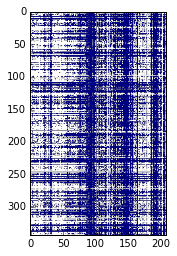

In [34]:
plt.imshow(main_table.as_matrix())

### Node dataframes

### Correlations

CHI_COM_W2_O1_E2_I2
CHI_COM_W4_O1_E2_I2

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


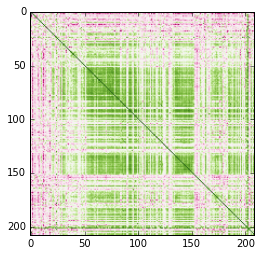

In [35]:
# var_dict = {'name': ['Wages', 'Exports', 'Imports'], 
#        'dataset': ['prd', 'trd', 'trd'], 
#        'levels': [['CI1', 'CI2', 'CI4'], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2','HS4']],
#            'agg_ref' : [CIIU, HS, HS],
#            'agg_str' : ['CIIU', 'HS', 'HS']}
    
# for var_dict in [var_dict_bra, var_dict_chi]:
for var_dict in [var_dict_chi]:    
    
    for geo in var_dict['geo_levels']:
        confs = list(itertools.product(*var_dict['levels']))
        v = len(var_dict['name'])

        for conf in confs:
            conf_name = geo+'_'+'_'.join([var_dict['name'][i][0]+conf[i][2::4] for i in range(v)])
            if assymetry_dict[conf_name] < max_allowed_assymetry:
                
                geo_col = [col for col in concat_data.columns if geo[:3] in col]

                main_table = pd.read_csv(hard_drive_path+path+conf_name+'_main_table.csv', index_col= 0 )

                robust_th = 5
                log_corr = np.log10(main_table).corr(min_periods = robust_th)
                del log_corr.index.name
                del log_corr.columns.name

                log_corr
                log_corr.to_csv(hard_drive_path+path+conf_name+'_log_corr.csv')
                print conf_name

#                 corr = main_table.corr()

log_corr.iloc[:5, :5]
plt.imshow(log_corr.as_matrix(),cmap = 'PiYG')

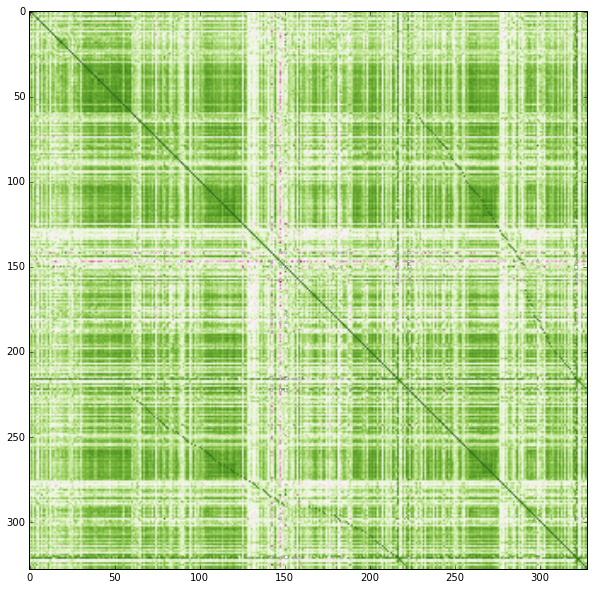

In [19]:
plt.figure(figsize = (10,10))
plt.imshow(log_corr.as_matrix(),cmap = 'PiYG')
plt.savefig('./Figures/log_corr_300.png', dpi=300)


### Demeaning

CHI_COM_W2_O1_E2_I2
CHI_COM_W4_O1_E2_I2


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


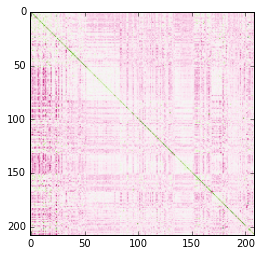

In [36]:
low_space = False

def demean_df(df):
    dm1 = df - df.mean()
    dm2 = (dm1.T - dm1.T.mean()).T
    
    demeaned_df = dm2
    
    return demeaned_df
# for var_dict in [var_dict_bra, var_dict_chi]:
for var_dict in [var_dict_chi]:    
    
    for geo in var_dict['geo_levels']:
        confs = list(itertools.product(*var_dict['levels']))
        v = len(var_dict['name'])

        for conf in confs:
            conf_name = geo+'_'+'_'.join([var_dict['name'][i][0]+conf[i][2::4] for i in range(v)])
            if assymetry_dict[conf_name] < max_allowed_assymetry:

                geo_col = [col for col in concat_data.columns if geo[:3] in col]

                log_corr = pd.read_csv(hard_drive_path+path+conf_name+'_log_corr.csv', index_col=0)

                dem_corr = demean_df(log_corr)

                ## standardizing after demeaning
                std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0)    

                name = 'std_dem_corr_'+conf_name

                df = pd.DataFrame(std_dem_corr.stack(), columns = [name])

                if low_space:
                    vars()[conf_name+'_std_dem_corr'] = df
                else:
                    df.to_csv(hard_drive_path+path+conf_name+'_std_dem_corr.csv')  
                print conf_name

            
plt.imshow(std_dem_corr.as_matrix(),cmap = 'PiYG')

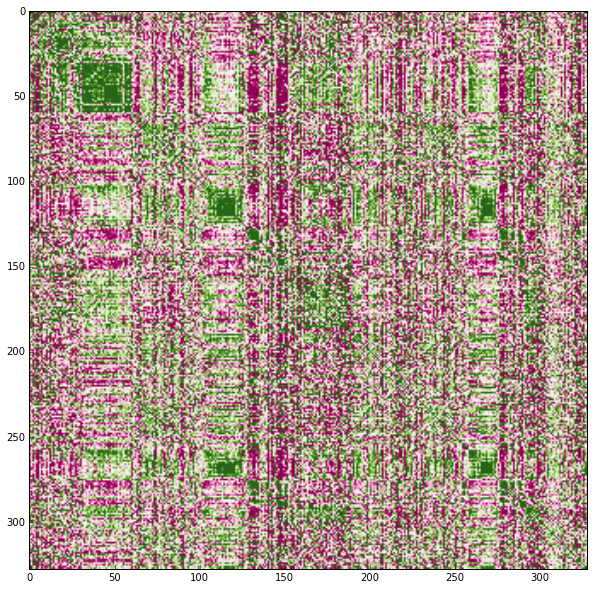

In [21]:
plt.figure(figsize = (10,10))
plt.imshow(std_dem_corr.as_matrix(),cmap = 'PiYG', vmin = -1, vmax = 1)
plt.savefig('./Figures/std_dem_corr_300.png', dpi=300)


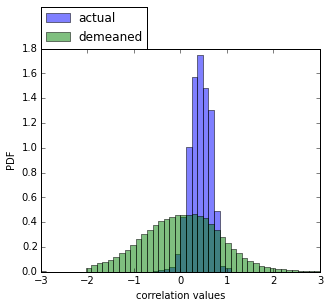

In [22]:
fig, ax = plt.subplots(1, figsize = (5,4))

def df_vals_hist(df, ax, bins = 50, color = 'w', label = ''):
    matrix_vals = df.as_matrix().flatten()
    valid_vals_mask = ~np.isnan(matrix_vals)
    p = np.percentile(matrix_vals[valid_vals_mask], 80)
    ax.hist([v for v in matrix_vals[valid_vals_mask] if v > -2], bins, range = (-3 , 3), alpha = 0.5, normed  =True, label = label)
#     ax.hist([v for v in matrix_vals[valid_vals_mask] if v > p], bins, range = (-1 , 1), color = 'k', alpha = 0.3, normed  =True)

    
j = 3
df_vals_hist(log_corr, ax, 50, color = 'g', label = 'actual')

df_vals_hist(std_dem_corr, ax, 50,color = 'r', label = 'demeaned')
ax.legend(loc = (0,1))
ax.set_xbound(-3, 3)
ax.set_ylabel('PDF')
ax.set_xlabel('correlation values')



### Edges data


In [37]:
from IPython.display import display, HTML
low_space = False

# for var_dict in [var_dict_bra, var_dict_chi]:
for var_dict in [var_dict_chi]:    
    
    for geo in var_dict['geo_levels']:
        confs = list(itertools.product(*var_dict['levels']))
        v = len(var_dict['name'])

        for conf in confs:
            conf_name = geo+'_'+'_'.join([var_dict['name'][i][0]+conf[i][2::4] for i in range(v)])
            if assymetry_dict[conf_name] < max_allowed_assymetry:
                name = 'std_dem_corr_'+conf_name

                if low_space:
                    df = vars()[conf_name+'_std_dem_corr']
                else:
                    df = pd.read_csv(hard_drive_path+path+conf_name+'_std_dem_corr.csv').rename({'Unnamed: 0': 'label_x','Unnamed: 1': 'label_y'}, axis  =1)

                edges = df#[(df[name] > df[name].quantile(4/5.)) & (df[name] < df[name].quantile(.99))]
                edges = edges.reset_index().rename({'level_0': 'label_x', 'level_1': 'label_y',name: 'weight_'+geo}, axis  =1)


                edges.to_csv(hard_drive_path+path+conf_name+'_edges.csv')
                print conf_name

# display(edges.sample(10))

CHI_COM_W2_O1_E2_I2
CHI_COM_W4_O1_E2_I2


# End of data processing and saving
# ______________________________

### Nodes color and size

In [ ]:

# ### Create and save node sizes and color for network plots:
# for conf in confs:
# #     (CIIU_lev, HS_Exp, HS_Imp) = conf
#     (CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = conf
#     col_name = ctry_str+'_'+geo_str+'_'+'_'.join([c for c in conf])+var_str
    
#     nodes = pd.read_csv('data/node_refs/'+col_name+'_nodes.csv', index_col = 0)

#     #color
#     from matplotlib import colors
#     nodes['color_code'] = nodes.att_A.rank(method = 'dense')
#     w = plt.cm.get_cmap('rainbow', len(nodes.color_code.unique()))

#     colors_hex = []
#     for i in range(w.N):
#         rgb = w(i)[:3] # will return rgba, we take only first 3 so we get rgb
#         colors_hex += [colors.rgb2hex(rgb)]

#     colors_hex = [w.encode('UTF8') for w in colors_hex]
#     code_hex = pd.DataFrame([nodes.color_code.unique(), colors_hex], index = ['color_code', 'color']).T

#     #size

#     value = nodes['node_value_USD']
#     # nodes['node_size'] = np.sqrt((value/value.median()).values)
#     nodes['node_size'] = 10 * np.power((value/value.median()).values, 1/2.)

#     nodes = nodes.merge(code_hex)

#     nodes.to_csv('data/node_refs/'+col_name+'_nodes_meta.csv')
    
# #     print len(nodes)

# nodes.sample(10)

In [ ]:
# import networkx as nx

# max_d = 10
# k = 0.05

# for max_d in [4, 7, 10, 20, 40]:  
#     print 'max degree: '+str(max_d)
#     for conf in confs:
# #         (CIIU_lev, HS_Exp, HS_Imp) = conf
#         (CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = conf
#         col_name = ctry_str+'_'+geo_str+'_'+'_'.join([c for c in conf])+var_str
#         print col_name

#         nodes = pd.read_csv('data/node_refs/'+col_name+'_nodes_meta.csv', index_col = 0)
#         edges = pd.read_csv('data/node_refs/'+col_name+'_edges.csv', index_col = 0)

#             ### Max degree = max_d
#         df1 = edges.groupby('label_x').apply(lambda x: x.nlargest(max_d, 'weight_'+geo_str)).reset_index(drop = True)
#         df2 = edges.groupby('label_y').apply(lambda x: x.nlargest(max_d, 'weight_'+geo_str)).reset_index(drop = True)
#         edges = df1.merge(df2, on = ['label_x', 'label_y', 'weight_'+geo_str]).reset_index(drop = True)


#         G = nx.from_pandas_dataframe(edges, 'label_x', 'label_y', 'weight_'+geo_str)
#         # nx.write_gexf(G,'networks/'+col_name+'.gexf')

#         print 'nodes: '+str(len(G.nodes()))
#         print 'edges: '+str(len(G.edges()))

#         # Main component
# #         grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
# #         G0=grcc[0]

#         # Subset of nodes
#         nodes = nodes.set_index('node_name').loc[G.nodes()]

#         #Perform Graph Drawing
#         plt.figure(figsize=(8, 8))
#         pos = nx.spring_layout(G, k=k)

#         nx.draw(G, pos, node_size = 10 * nodes.node_size.values, alpha=.6, node_color= list(nodes.color.values), edgelist = [])
#         nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
#         #     plt.savefig('../DataViva/Figures/'+'_'+kw+'_'+name)
#         plt.show()

### Bokeh

In [ ]:
# import sys    
# reload(sys)  
# sys.setdefaultencoding('utf8')a
# pd.options.display.max_rows = 999

In [ ]:
# nodes = pd.read_csv('data/node_refs/'+col_name+'_nodes_meta.csv', index_col = 0)
# print len(nodes)
# edges = pd.read_csv('data/node_refs/'+col_name+'_edges.csv', index_col = 0)

# ### Max degree = max_d
# df1 = edges.groupby('label_x').apply(lambda x: x.nlargest(max_d, 'weight_COM')).reset_index(drop = True)
# df2 = edges.groupby('label_y').apply(lambda x: x.nlargest(max_d, 'weight_COM')).reset_index(drop = True)
# edges = df1.merge(df2, on = ['label_x', 'label_y', 'weight_COM']).reset_index(drop = True)


# G = nx.from_pandas_dataframe(edges, 'label_x', 'label_y', 'weight_'+geo_str)
# nx.triangles(G)

In [ ]:
# import seaborn as sns
# import math

# from bokeh.io import show, output_file
# from bokeh.plotting import figure
# from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, MultiLine, NodesOnly, NodesAndLinkedEdges
# from bokeh.models.graphs import from_networkx
# from bokeh.models.tools import HoverTool

# k = .05
# max_d = 10

# for conf in [confs[2]]:
#     (CIIU_lev, HS_Exp, HS_Imp) = conf
#     col_name = ctry_str+'_'+geo_str+'_'+'_'.join([c for c in conf])+var_str
#     print col_name
    
#     for i in range(10):


#         nodes = pd.read_csv('data/node_refs/'+col_name+'_nodes_meta.csv', index_col = 0)
#         print len(nodes)
#         edges = pd.read_csv('data/node_refs/'+col_name+'_edges.csv', index_col = 0)

#         ### Max degree = max_d
#         df1 = edges.groupby('label_x').apply(lambda x: x.nlargest(max_d, 'weight_COM')).reset_index(drop = True)
#         df2 = edges.groupby('label_y').apply(lambda x: x.nlargest(max_d, 'weight_COM')).reset_index(drop = True)
#         edges = df1.merge(df2, on = ['label_x', 'label_y', 'weight_COM']).reset_index(drop = True)

#         G = nx.from_pandas_dataframe(edges, 'label_x', 'label_y', 'weight_'+geo_str)


#         ### Subgraph - neighborhood
#     #         nodes_sel = select_nodes_by_kw(G, ['Wine','grape', 'Grape','bebidas fermentadas'])
#     #     nodes_sel = [ 'Output ofPesca maritima ']
#     #     nodes_sel = select_nodes_by_kw(G, ['Silvicultura'])
#         nodes_sel = np.random.choice(G.nodes(), 1)

#         G = G.subgraph(second_neighbors(G, nodes_sel, second_order=True))  
#         nodes = nodes.set_index('node_name').loc[G.nodes()].reset_index()
#         edges = edges.loc[(edges.label_x.isin(G.nodes())) & (edges.label_y.isin(G.nodes()))]

#         # nx.write_gexf(G,'networks/'+col_name+'.gexf')

#     #     Networkx drawing
#         #Perform Graph Drawing
#         plt.figure(figsize=(8, 8))
#         pos = nx.spring_layout(G, k=0.15)

#         nx.draw(G, pos, node_size = 10 * nodes.node_size.values, alpha=.6, node_color= list(nodes.color.values), edgelist = [])
#         nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
#         #     plt.savefig('../DataViva/Figures/'+'_'+kw+'_'+name)
#         plt.show()

#         ####

#     #     Bokeh drawing
#         ####

#         N = len(nodes)
#         node_indices = list(range(N))
#         # sizes = np.linspace(10, 20, N)
#         # node_sizes = np.sqrt(nodes['node_size'].values)

#         plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1))

#         #####

#         graph = from_networkx(G, nx.spring_layout, center=(0,0), k = k)

#         graph.node_renderer.data_source.add(list(nodes['color'].values), 'color')
#         graph.node_renderer.data_source.add(list(nodes['node_name'].values), 'node_name')
#         graph.node_renderer.data_source.add(list(2*nodes['node_size'].values), 'node_size')

#         graph.node_renderer.glyph = Circle(size='node_size', fill_color='color')
#         graph.node_renderer.selection_glyph = Circle(size=15, fill_color='#808000')
#         graph.node_renderer.hover_glyph = Circle(size=15, fill_color='#808000')

#         graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.2, line_width=1)
#         graph.edge_renderer.selection_glyph = MultiLine(line_color='#808000', line_width=5)
#         graph.edge_renderer.hover_glyph = MultiLine(line_color='#808000', line_width=5)
#         graph.selection_policy = NodesAndLinkedEdges()

#         plot.renderers.append(graph)

#         hover = HoverTool(plot=plot, tooltips=dict(act="@node_name", value="@node_size"))
#         # hover = HoverTool(tooltips = [('Info', '@node_name'),('(x,y)', '($x, $y)')])

#         plot.add_tools(hover)

# #         output_file("networkx_graph.html")
#         # output_notebook()
#         show(plot)

#         nodes = nodes.sort_values(by = 'node_size', ascending = False)
#         sns.barplot(x='node_size',y='node_name',palette=nodes['color'], data=nodes, edgecolor = 'None')


In [ ]:
# nodes_sel = np.random.choice(G.nodes(), 1)
# nodes_sel
# G = G.subgraph(second_neighbors(G, nodes_sel, second_order=False)) 

In [ ]:
# plt.hist(G.degree().values(), 30)
# plt.show()

In [ ]:
# [s for s in G.nodes() if 'Pesca' in s]

In [ ]:
# def select_nodes_by_kw(G = G0, keyword_list = []):
#     result_list = []
#     for kw in keyword_list:
#         result_list += [label for label in G0.nodes() if kw in label]
#     return result_list

# def second_neighbors(graph, nodes, second_order = True):
#     """                                                                                                                          
#     a generator that yeilds second neighbors of node in graph                                                                    
#     neighbors are not not unique!                                                                                                
#     """
#     neighbor_list = [nodes]

#     for i in range(len(nodes)):
#         neighbor_list += [graph.neighbors(nodes[i])]
        
#         if second_order == True:
#             for n in graph.neighbors(nodes[i]):
#                     neighbor_list += [graph.neighbors(n)]


#     return list(set([item for sublist in neighbor_list for item in sublist]))

In [ ]:
# # nodes = ['Imports of 55 - Man-made staple fibres', 'Output de Fabricación de tejidos de punto y ganchillo',
# #        'Output de Fabricación de otros artículos textiles n.c.p.',
# #        'Output de Comercio al por mayor de productos textiles, productos confeccionados para uso doméstico',
# #         'Output de Preparación e hilatura de fibras textiles', 'Imports of 60 - Fabrics; knitted or crocheted',
# #         'Output de Acabado de productos textiles', 'Imports of 52 - Cotton', 'Output de Confección de prendas de vestir, excepto prendas de piel',
# #         'Imports of 58 - Fabrics; special woven fabrics, tufted textile fabrics, lace, tapestries, trimmings, embroidery']

# # nodes = ['Imports of 58 - Fabrics; special woven fabrics, tufted textile fabrics, lace, tapestries, trimmings, embroidery',
# # 'Imports of 60 - Fabrics; knitted or crocheted' , 'Imports of 52 - Cotton' , 'Imports of 55 - Man-made staple fibres', 
# #         'Imports of 63 - Textiles, made up articles; sets; worn clothing and worn textile articles; rags',
# #         'Imports of 59 - Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use']


# # nodes = [ 'Output de Pesca de agua dulce ','Output de Pesca marítima ', 'Output de Acuicultura marítima ']
# # G0.remove_node('Output de Actividades de juegos de azar y apuestas')

# # matching = [s for s in G0.nodes() if "Copper" in s]
# # nodes = ['Output de Extracci\xc3\xb3n de otros minerales metal\xc3\xadferos no ferrosos n.c.p.', 
# #         'Output de Extracción de otros minerales no metálicos n.c.p.',
# #         'Exports of 7204 - Ferrous waste and scrap; remelting scrap ingots of iron or steel',
# #         'Exports of 7404 - Copper; waste and scrap', 'Imports of 74 - Copper and articles thereof',
# #         'Exports of 7326 - Iron or steel; articles, n.e.c. in chapter 73',
# #         'Exports of 7602 - Aluminium; waste and scrap']

# # node = ['Imports of 58 - Fabrics; special woven fabrics, tufted textile fabrics, lace, tapestries, trimmings, embroidery']

# nodes = select_nodes_by_kw(G0, ['Wine','grape', 'Grape','bebidas fermentadas'])
# k = G0.subgraph(second_neighbors(G0, nodes, second_order=False))  

# plt.figure(figsize=(8, 8))

# #colors
# colors = urbanity.loc[k.nodes()].mean_urbanity.values

# lab={}
# for i in range(len(k.nodes())):
#     node_name = k.nodes()[i]
#     l = str(i).zfill(2) + k.nodes()[i][0]
#     lab[node_name] = l

# posi = nx.spring_layout(k, k=0.14)

# # node_size[node_size.index.str.contains('Copper')].sort_values()

# nx.draw(k, posi, node_size = node_size.loc[list(lab)], cmap=cmap,node_color=colors, vmin = vmin, vmax = vmax, 
#         edge_color='.7', alpha=.6)

# nx.draw_networkx_labels(k, pos=posi, labels = lab)

# plt.show()

# import collections
# pd.set_option('display.max_colwidth', -1)
# inv_lab = {v: k for k, v in lab.iteritems()}
# inv_lab
# abbr = pd.DataFrame(inv_lab, index = ['abbr']).T
# abbr

# d = dict(abbr.loc[lab.values()].sort_index())

# # print [k, v for k, v in ()]
# print d['abbr'].str[:70]


In [ ]:
# ### PLOT CORR VALUES

# for i in range(4):

#     rk = pd.DataFrame(df_list[i].reset_index().groupby('level_0').mean().rank())
#     rk.columns = ['rank']
    
#     dem_corr = demean_df(df_list[i].unstack())
#     dem_corr.columns = dem_corr.columns.droplevel(0)

#     ## standardizing after demeaning
#     std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0)   

#     df_corr = df_list[i].reset_index().merge(rk.reset_index())
#     df_corr.columns = [u'level_0', u'level_1', 0, u'rank']
#     df_std_dem = std_dem_corr.stack().reset_index().merge(rk.reset_index())


#     dfs = [df_corr, df_std_dem]
#     fig, axs = plt.subplots(1, 2, figsize = (10, 4))
#     for i in range(2):
#         df = dfs[i]
#         ax = axs[i]
#         df.sample(10000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', alpha = .1, ax = ax, color = '.5')

#         if i == 0:
#             ax.set_xlim(-.5, 1)
#             ax.set_title('Pearson corr values \n for all nodes, ' +name)
#             hilite = df_corr.loc[df_std_dem[0] > np.percentile(df_std_dem[0], 100 * 4/5.)]
#             hilite.sample(3000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', ax = ax, alpha = .1)


#         if i ==1:
#             ax.axvline(x = df[0].quantile(4/5.), linestyle = '-', color = 'b')
#             ax.axvline(x = df[0].quantile(.99), linestyle = '-', color = 'b')
#             ax.set_xlim(-4, 4)
#             ax.set_title('Demeaned and standardized \n corr values, '+name)
# #             hilite = df_std_dem.loc[df_std_dem[0] > np.percentile(df_std_dem[0], 100 * 4/5.)]
# #             hilite.sample(1000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', ax = ax)

#     plt.show()



In [ ]:
# #Node size info (maybe should be done when the node labels are set)

# df = trade_bra.merge(HS[['HS ID 2', 'HS ID 4']].drop_duplicates()).groupby('HS ID 2').sum()
# nds_y = nodes_df.loc[[row for row in nodes_df.index if 'Exports' in row]].reset_index().merge(df[['Exports']].reset_index(), left_on = 'att_A', right_on = 'HS ID 2').drop('HS ID 2', axis = 1).rename({'Exports' : 'value_USD'}, axis = 1)
# nds_z = nodes_df.loc[[row for row in nodes_df.index if 'Imports' in row]].reset_index().merge(df[['Imports']].reset_index(), left_on = 'att_A', right_on = 'HS ID 2').drop('HS ID 2', axis = 1).rename({'Imports' : 'value_USD'}, axis = 1)

# # df = wages_bra.merge(HS['CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev].drop_duplicates()).groupby(['CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev]).sum()

# nds_x = nodes_df.loc[[row for row in nodes_df.index if 'Wages' in row]].reset_index()
# nds_x['value_USD'] = 1762904178 #shortcut

# nodes_df = pd.concat([nds_x, nds_y, nds_z]).set_index('node_name')

# # colors...
# # nodes_df.merge(CNAE[['CNAE ID D', 'CNAE ID S']], left_on = 'att_A', right_on = 'CNAE ID D', how = 'left').sample(30)#.loc[G.nodes()]

## Other

In [ ]:
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2', index = False)
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2_i')

In [ ]:
# df = pd.read_csv('data/Corr/corr_MER_S_GG_2_2')

In [ ]:
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# pp = sns.pairplot(df.sample(10000).dropna(), diag_kind="kde", markers="+",
#              plot_kws=dict(s=50, edgecolor="b", linewidth=1, alpha = .01),
#              diag_kws=dict(shade=True))
# [[ax.set_ylim(-.5,1) for ax in ax_list] for ax_list in pp.axes]
# x = [-.5, 1]
# [[ax.plot(x,x, c = '.5', linestyle = '--') for ax in ax_list] for ax_list in pp.axes]

# plt.show()